# Libs

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import datetime as dt
import sys
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tqdm.notebook import tqdm
import warnings
import pickle as pkl
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from lib.data_loader import DataLoader
from lib.HM_algorithms.preprocessors import HMPreprocessor

# functions

In [2]:
def create_model():
        
    dense_input = tf.keras.layers.Input(shape=(38,))
    
    emb_input1 = tf.keras.layers.Input(shape=(1,))
    emb_input2 = tf.keras.layers.Input(shape=(1,))
    emb_input3 = tf.keras.layers.Input(shape=(1,))
    emb_input4 = tf.keras.layers.Input(shape=(1,))
    
    embedding1 = tf.keras.layers.Embedding(10, 2)(emb_input1)
    embedding2 = tf.keras.layers.Embedding(10, 2)(emb_input2)
    embedding3 = tf.keras.layers.Embedding(10, 2)(emb_input3)
    embedding4 = tf.keras.layers.Embedding(10, 2)(emb_input4)

    con_layer = tf.keras.layers.Concatenate()([dense_input,
                                                     tf.keras.layers.Flatten()(embedding1),
                                                     tf.keras.layers.Flatten()(embedding2),
                                                     tf.keras.layers.Flatten()(embedding3),
                                                     tf.keras.layers.Flatten()(embedding4)])
    
    x = tf.keras.layers.Dense(128, activation='relu')(con_layer)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    
    output_layer = tf.keras.layers.Dense(1, activation='relu')(x)
    
    model = tf.keras.Model(inputs=[dense_input, emb_input1, emb_input2, emb_input3, emb_input4],
                  outputs=output_layer)
    
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    
    model.summary()

    return model

def create_model_seq():
        
    dense_input = tf.keras.layers.Input(shape=(5, 38))
    
    emb_input1 = tf.keras.layers.Input(shape=(5, 1))
    emb_input2 = tf.keras.layers.Input(shape=(5, 1))
    emb_input3 = tf.keras.layers.Input(shape=(5, 1))
    emb_input4 = tf.keras.layers.Input(shape=(5, 1))
    
    
    embedding1 = tf.keras.layers.Embedding(10, 2)(emb_input1)
    embedding2 = tf.keras.layers.Embedding(10, 2)(emb_input2)
    embedding3 = tf.keras.layers.Embedding(10, 2)(emb_input3)
    embedding4 = tf.keras.layers.Embedding(10, 2)(emb_input4)
    
    
        
    embedding1 = tf.keras.layers.Reshape((5, 2))(embedding1)
    embedding2 = tf.keras.layers.Reshape((5, 2))(embedding2)
    embedding3 = tf.keras.layers.Reshape((5, 2))(embedding3)
    embedding4 = tf.keras.layers.Reshape((5, 2))(embedding4)
    

    con_layer = tf.keras.layers.Concatenate()([dense_input,
                                                     embedding1,
                                                     embedding2,
                                                     embedding3,
                                                     embedding4])
    
    x = tf.keras.layers.LSTM(128, activation='relu')(con_layer)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    
    output_layer = tf.keras.layers.Dense(1, activation='relu')(x)
    
    model = tf.keras.Model(inputs=[dense_input, emb_input1, emb_input2, emb_input3, emb_input4],
                  outputs=output_layer)
    
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    return model

In [3]:
def make_dataset(df_data, times_df, labels=False):
    total = len(times_df)

    df = df_data.merge(times_df)
    x = df[col_order]
    y = df['pv_measurement']

    return x, y


In [4]:
def prepare_X_data(X, emb_cols):

    emb_feats = [4, 16, 19, 26]
    
    x_emb = [X[:, i].reshape(-1, 1) for i in emb_feats]

    data_without_columns = np.delete(X, emb_feats + [38, 39], axis=-1)

    return [data_without_columns, *x_emb]

def preprare_y_data(x):
    return x.reshape((-1, 1))

def prepare_X_data_seq(X, emb_cols):

    emb_feats = [4, 16, 19, 26]
    
    x_emb = [X[:, :, i].reshape(-1, 5, 1) for i in emb_feats]

    data_without_columns = np.delete(X, emb_feats + [38, 39], axis=-1)

    return [data_without_columns, *x_emb]

In [5]:
def MAE_exp(y_true, y_pred):
    # Przekształcenie wyjścia sieci (y_pred) i wartości docelowej (y_true) za pomocą funkcji exp
    y_true_exp = tf.exp(tf.cast(y_true, tf.double))
    y_pred_exp = tf.exp(tf.cast(y_pred, tf.double))
    
    # Obliczanie MAE między przekształconymi wartościami
    mae = tf.reduce_mean(tf.abs(y_true_exp - y_pred_exp))
    
    return mae

In [6]:
def select_records_in_time_range(df, x):
    
    t = pd.Timedelta(hours=1)
    time_column = 'date_forecast'
    
    start_time = x - t
    end_time = x
    
    selected_records = df[(df[time_column] >= start_time) & (df[time_column] <= end_time)]
    
    return selected_records

def make_dataset_seq(df_data, times_df, labels=False):
    total = len(times_df)
    if labels:
        times = times_df['date_forecast']
        return_arr = np.array([[select_records_in_time_range(df_data, i),
                               z] for i, z in tqdm(zip(times_df['date_forecast'],
                                                 times_df['pv_measurement']),
                                                   total=total)])
        return np.array([i[0] for i in return_arr]), np.array([i[1] for i in return_arr])
    else:
        return_arr = np.array([select_records_in_time_range(df_data, i) for i in tqdm(times_df['date_forecast'],
                                                                                      total=total)])
        return return_arr, None


In [7]:
def save_open_pkl(fname):

    with open(fname, 'rb') as f:
        d = pkl.load(f)
    return d

# classes

In [8]:
class HMPreprocessor:

    def __init__(self, X_train, y_train, X_val, y_val, X_test, validation_split=0.25):

        self.bonus_params_dict = {}
        self.embedding_dict = {}
        
        self.__initialize_cols()

        
        self.y_train = np.log(1 + y_train)
        self.y_val = np.log(1 + y_val)

        X_train, X_val1, y_train, y_val1 = train_test_split(X_train, self.y_train, test_size=validation_split)
        
        self.__calculate_inner_parameters(X_train)

        self.X_train = X_train
        self.y_train = y_train

        self.X_val1 = X_val1
        self.y_val1 = y_val1

        self.X_val2 = X_val
        self.y_val2 = np.log(1 + y_val)

        self.X_test = X_test
    
    def _process_snow_density(self, df, col):

        result_df = df.copy()

        result_df[col][~pd.isna(result_df[col])] = 1
        result_df[col][pd.isna(result_df[col])] = 0

        return result_df

    def _remove_columns(self, df, cols):
        return df.drop(columns=cols)

    def _dev_100(self, df, cols):
        result_df = df.copy()
        
        result_df[cols] = result_df[cols] / 100
        return result_df

    def _if_log(self, df, cols, max_val=4):
        
        result_df = df.copy()

        for col in cols:
            a = result_df[col][result_df[col] > 0]

            if col in self.bonus_params_dict:
                b = 0
            else:
                b = 0
                self.bonus_params_dict[col] = b

            result_df[col] = result_df[col].apply(lambda x: np.log(x + 1))
        
        return result_df

    def _embedding_dim(self, df, cols):
        result_df = df.copy()

        for col in cols:

            if col in self.embedding_dict:
                emb_dict = self.embedding_dict[col]
            else:
                # Pobieramy unikalne wartości z kolumny 'Kolumna'
                uniques = result_df[col].unique()

                emb_dict = {val: idx for idx, val in enumerate(uniques)}
                self.embedding_dict[col] = emb_dict

            result_df[col] = result_df[col].map(emb_dict)

        return result_df

    def _log_plus_std(self, df, cols):

        result_df = df.copy()

        for col in cols:
            result_df[col] = result_df[col].apply(lambda x: np.log(x + 1))

        scaler = StandardScaler()
        result_df[cols] = scaler.fit_transform(result_df[cols])

        return result_df

    def _sun_sin_cos(self, df, col):
        result_df = df.copy()

        a = np.sin(2 * np.pi * df[col] / 360.)
        b = np.cos(2 * np.pi * df[col] / 360.)

        result_df = df.drop(columns=[col])
        result_df['sun_sin'] = a
        result_df['sun_cos'] = b

        return result_df

    def _month_sin_cos(self, df, col):
        result_df = df.copy()

        data = result_df[col].dt.dayofyear

        result_df['month_sin'] = np.sin(2 * np.pi * data / 365.0)
        result_df['month_cos'] = np.cos(2 * np.pi * data / 365.0)

        return result_df

    def _std(self, df, cols):
        result_df = df.copy()

        scaler = StandardScaler()
        result_df[cols] = scaler.fit_transform(result_df[cols])

        return result_df

    def _whole_pipeline(self, df):

        result_df = df.copy()

        pipeline = [(self._month_sin_cos, self.month_col),
                    (self._remove_columns, self.rm_cols),
                    (self._process_snow_density, self.process_snow_density_cols),
                    (self._dev_100, self.dev_100_cols),
                    (self._if_log, self.if_log_cols),
                    (self._embedding_dim, self.emb_cols),
                    (self._log_plus_std, self.log_cols),
                    (self._sun_sin_cos, self.sun_col),
                    (self._std, self.std_cols)]

        for fun, cols in pipeline:
            result_df = fun(result_df, cols)

        return result_df

    def get_tranformed_data(self):

        X_train = self._whole_pipeline(self.X_train)
        X_val1 = self._whole_pipeline(self.X_val1)
        X_val2 = self._whole_pipeline(self.X_val2)
        X_test = self._whole_pipeline(self.X_test)

        return_dict = {
            'X_train': X_train,
            'y_train': self.y_train,
            
            'X_val1': X_val1,
            'y_val1': self.y_val1,
            
            'X_val2': X_val2,
            'y_val2': self.y_val2,
            
            'X_test': X_test
        }
        return return_dict

    def __calculate_inner_parameters(self, df):
        _ = self._whole_pipeline(df)
        return None
        

    def __initialize_cols(self):
        
        self.month_col = 'date_forecast'
        
        self.rm_cols = ['cloud_base_agl:m',
                        'elevation:m',
                        'is_day:idx',
                        'snow_drift:idx',
                        'wind_speed_w_1000hPa:ms',
                        'date_calc',
                        'date_forecast',
                        'ceiling_height_agl:m']

        self.process_snow_density_cols = 'snow_density:kgm3'

        self.dev_100_cols = ['effective_cloud_cover:p',
                             'prob_rime:p',
                             'relative_humidity_1000hPa:p',
                             'total_cloud_cover:p']

        self.if_log_cols = ['clear_sky_energy_1h:J',
                            'clear_sky_rad:W',
                            'diffuse_rad:W',
                            'direct_rad:W',
                            'diffuse_rad_1h:J',
                            'direct_rad_1h:J',
                            'fresh_snow_12h:cm',
                            'fresh_snow_1h:cm',
                            'fresh_snow_24h:cm',
                            'fresh_snow_3h:cm',
                            'fresh_snow_6h:cm',
                            'precip_5min:mm',
                            'rain_water:kgm2',
                            'snow_depth:cm',
                            'snow_melt_10min:mm',
                            'snow_water:kgm2',
                            'super_cooled_liquid_water:kgm2']

        self.emb_cols = ['is_in_shadow:idx',
                         'precip_type_5min:idx',
                         'dew_or_rime:idx',
                         'Category',
                         'Data_Type'
                         ]

        self.log_cols = ['wind_speed_10m:ms',
                         'visibility:m']

        self.sun_col = 'sun_azimuth:d'

        self.std_cols = ['absolute_humidity_2m:gm3',
                         'air_density_2m:kgm3',
                         'dew_point_2m:K',
                         'msl_pressure:hPa',
                         'pressure_100m:hPa',
                         'pressure_50m:hPa',
                         'sfc_pressure:hPa',
                         'sun_elevation:d',
                         't_1000hPa:K',
                         'wind_speed_u_10m:ms']

In [9]:
class HMSeqPreprocessor:

    def __init__(self, X_train, y_train, X_val, y_val, X_test, validation_split=0.25):

        self.bonus_params_dict = {}
        self.embedding_dict = {}
        
        self.__initialize_cols()

        
        self.y_train = np.log(1 + y_train)
        self.y_val = np.log(1 + y_val)

        X_train, X_val1, y_train, y_val1 = train_test_split(X_train, self.y_train, test_size=validation_split)
        
        self.__calculate_inner_parameters(pd.concat(X_train))

        self.X_train = X_train
        self.y_train = y_train

        self.X_val1 = X_val1
        self.y_val1 = y_val1

        self.X_val2 = X_val
        self.y_val2 = np.log(1 + y_val)

        self.X_test = X_test
    
    def _process_snow_density(self, df, col):

        result_df = df.copy()

        result_df[col][~pd.isna(result_df[col])] = 1
        result_df[col][pd.isna(result_df[col])] = 0

        return result_df

    def _remove_columns(self, df, cols):
        return df.drop(columns=cols)

    def _dev_100(self, df, cols):
        result_df = df.copy()
        
        result_df[cols] = result_df[cols] / 100
        return result_df

    def _if_log(self, df, cols, max_val=4):
        
        result_df = df.copy()

        for col in cols:
            a = result_df[col][result_df[col] > 0]

            if col in self.bonus_params_dict:
                b = 0
            else:
                b = 0
                self.bonus_params_dict[col] = b

            result_df[col] = result_df[col].apply(lambda x: np.log(x + 1))
        
        return result_df

    def _embedding_dim(self, df, cols):
        result_df = df.copy()

        for col in cols:

            if col in self.embedding_dict:
                emb_dict = self.embedding_dict[col]
            else:

                uniques = result_df[col].unique()

                emb_dict = {val: idx for idx, val in enumerate(uniques)}
                self.embedding_dict[col] = emb_dict

            result_df[col] = result_df[col].map(emb_dict)

        return result_df

    def _log_plus_std(self, df, cols):

        result_df = df.copy()

        for col in cols:
            result_df[col] = result_df[col].apply(lambda x: np.log(x + 1))

        scaler = StandardScaler()
        result_df[cols] = scaler.fit_transform(result_df[cols])

        return result_df

    def _sun_sin_cos(self, df, col):
        result_df = df.copy()

        a = np.sin(2 * np.pi * df[col] / 360.)
        b = np.cos(2 * np.pi * df[col] / 360.)

        result_df = df.drop(columns=[col])
        result_df['sun_sin'] = a
        result_df['sun_cos'] = b

        return result_df

    def _month_sin_cos(self, df, col):
        result_df = df.copy()

        # Obliczenie dnia roku
        data = result_df[col].dt.dayofyear

        # Obliczenie sinus i cosinus z dnia roku
        result_df['month_sin'] = np.sin(2 * np.pi * data / 365.0)
        result_df['month_cos'] = np.cos(2 * np.pi * data / 365.0)

        return result_df

    def _std(self, df, cols):
        result_df = df.copy()

        scaler = StandardScaler()
        result_df[cols] = scaler.fit_transform(result_df[cols])

        return result_df

    def _whole_pipeline(self, df):

        result_df = df.copy()

        pipeline = [(self._month_sin_cos, self.month_col),
                    (self._remove_columns, self.rm_cols),
                    (self._process_snow_density, self.process_snow_density_cols),
                    (self._dev_100, self.dev_100_cols),
                    (self._if_log, self.if_log_cols),
                    (self._embedding_dim, self.emb_cols),
                    (self._log_plus_std, self.log_cols),
                    (self._sun_sin_cos, self.sun_col),
                    (self._std, self.std_cols)]

        for fun, cols in pipeline:
            result_df = fun(result_df, cols)

        return result_df

    def get_tranformed_data(self):

        X_train = np.array([self._whole_pipeline(i) for i in tqdm(self.X_train, total=len(self.X_train))])
        X_val1 = np.array([self._whole_pipeline(i) for i in tqdm(self.X_val1, total=len(self.X_val1))])
        X_val2 = np.array([self._whole_pipeline(i) for i in tqdm(self.X_val2, total=len(self.X_val2))])
        X_test = np.array([self._whole_pipeline(i) for i in tqdm(self.X_test, total=len(self.X_test))])

        return_dict = {
            'X_train': X_train,
            'y_train': self.y_train,
            
            'X_val1': X_val1,
            'y_val1': self.y_val1,
            
            'X_val2': X_val2,
            'y_val2': self.y_val2,
            
            'X_test': X_test
        }
        return return_dict

    def __calculate_inner_parameters(self, df):
        _ = self._whole_pipeline(df)
        return None
        

    def __initialize_cols(self):
        
        self.month_col = 'date_forecast'
        
        self.rm_cols = ['cloud_base_agl:m',
                        'elevation:m',
                        'is_day:idx',
                        'snow_drift:idx',
                        'wind_speed_w_1000hPa:ms',
                        'date_calc',
                        'date_forecast',
                        'ceiling_height_agl:m']

        self.process_snow_density_cols = 'snow_density:kgm3'

        self.dev_100_cols = ['effective_cloud_cover:p',
                             'prob_rime:p',
                             'relative_humidity_1000hPa:p',
                             'total_cloud_cover:p']

        self.if_log_cols = ['clear_sky_energy_1h:J',
                            'clear_sky_rad:W',
                            'diffuse_rad:W',
                            'direct_rad:W',
                            'diffuse_rad_1h:J',
                            'direct_rad_1h:J',
                            'fresh_snow_12h:cm',
                            'fresh_snow_1h:cm',
                            'fresh_snow_24h:cm',
                            'fresh_snow_3h:cm',
                            'fresh_snow_6h:cm',
                            'precip_5min:mm',
                            'rain_water:kgm2',
                            'snow_depth:cm',
                            'snow_melt_10min:mm',
                            'snow_water:kgm2',
                            'super_cooled_liquid_water:kgm2']

        self.emb_cols = ['is_in_shadow:idx',
                         'precip_type_5min:idx',
                         'dew_or_rime:idx',
                         'Category',
                         'Data_Type'
                         ]

        self.log_cols = ['wind_speed_10m:ms',
                         'visibility:m']

        self.sun_col = 'sun_azimuth:d'

        self.std_cols = ['absolute_humidity_2m:gm3',
                         'air_density_2m:kgm3',
                         'dew_point_2m:K',
                         'msl_pressure:hPa',
                         'pressure_100m:hPa',
                         'pressure_50m:hPa',
                         'sfc_pressure:hPa',
                         'sun_elevation:d',
                         't_1000hPa:K',
                         'wind_speed_u_10m:ms']

# Solution

## load data

In [10]:
data_loader = DataLoader('data', categories=['A', 'B', 'C'])

data\A\train_targets.parquet: no. sampples: 34085
data\B\train_targets.parquet: no. sampples: 32848
data\C\train_targets.parquet: no. sampples: 32155
data\A\X_train_observed.parquet: no. sampples: 118669
data\A\X_train_estimated.parquet: no. sampples: 17576
data\B\X_train_observed.parquet: no. sampples: 116929
data\B\X_train_estimated.parquet: no. sampples: 17576
data\C\X_train_observed.parquet: no. sampples: 116825
data\C\X_train_estimated.parquet: no. sampples: 17576
data\A\X_test_estimated.parquet: no. sampples: 2880
data\B\X_test_estimated.parquet: no. sampples: 2880
data\C\X_test_estimated.parquet: no. sampples: 2880


In [11]:
sample_sub = pd.read_csv(os.path.join('data', 'test.csv'))
sample_sub = sample_sub.rename(columns={'time': 'date_forecast', 'location': 'Category', 'prediction': 'pv_measurement'})
sample_sub.drop(columns=['id'])
sample_sub['date_forecast'] = pd.to_datetime(sample_sub['date_forecast'])

sample_sub_A = sample_sub[sample_sub['Category'] == 'A']
sample_sub_B = sample_sub[sample_sub['Category'] == 'B']
sample_sub_C = sample_sub[sample_sub['Category'] == 'C']
sample_sub_A.head()

,id,date_forecast,pv_measurement,Category
0,0,2023-05-01 00:00:00,0,A
1,1,2023-05-01 01:00:00,0,A
2,2,2023-05-01 02:00:00,0,A
3,3,2023-05-01 03:00:00,0,A
4,4,2023-05-01 04:00:00,0,A


## Split data

In [12]:

XA_train = data_loader.X_train[(data_loader.X_train['Category'] == 'A') & (data_loader.X_train['Data_Type'] == 'observed')]
XB_train = data_loader.X_train[(data_loader.X_train['Category'] == 'B') & (data_loader.X_train['Data_Type'] == 'observed')]
XC_train = data_loader.X_train[(data_loader.X_train['Category'] == 'C') & (data_loader.X_train['Data_Type'] == 'observed')]

yA_train = data_loader.y_train[(data_loader.y_train['Category'] == 'A')]
yB_train = data_loader.y_train[(data_loader.y_train['Category'] == 'B')]
yC_train = data_loader.y_train[(data_loader.y_train['Category'] == 'C')]

XA_val = data_loader.X_train[(data_loader.X_train['Category'] == 'A') & (data_loader.X_train['Data_Type'] == 'estimated')]
XB_val = data_loader.X_train[(data_loader.X_train['Category'] == 'B') & (data_loader.X_train['Data_Type'] == 'estimated')]
XC_val = data_loader.X_train[(data_loader.X_train['Category'] == 'C') & (data_loader.X_train['Data_Type'] == 'estimated')]

yA_val = data_loader.y_train[(data_loader.X_train['Category'] == 'A') & (data_loader.X_train['Data_Type'] == 'estimated')]
yB_val = data_loader.y_train[(data_loader.X_train['Category'] == 'A') & (data_loader.X_train['Data_Type'] == 'estimated')]
yC_val = data_loader.y_train[(data_loader.X_train['Category'] == 'A') & (data_loader.X_train['Data_Type'] == 'estimated')]

XA_test = data_loader.X_test[(data_loader.X_test['Category'] == 'A') & (data_loader.X_test['Data_Type'] == 'estimated')]
XB_test = data_loader.X_test[(data_loader.X_test['Category'] == 'B') & (data_loader.X_test['Data_Type'] == 'estimated')]
XC_test = data_loader.X_test[(data_loader.X_test['Category'] == 'C') & (data_loader.X_test['Data_Type'] == 'estimated')]

col_order = XA_train.columns

XA_test_p, _ = make_dataset(XA_test, sample_sub_A, labels=True)
XB_test_p, _ = make_dataset(XB_test, sample_sub_B, labels=True)
XC_test_p, _ = make_dataset(XC_test, sample_sub_C, labels=True)

XA_train_p, yA_train_p = make_dataset(XA_train, yA_train, labels=True)
XB_train_p, yB_train_p = make_dataset(XB_train, yB_train, labels=True)
XC_train_p, yC_train_p = make_dataset(XC_train, yC_train, labels=True)

XA_val_p, yA_val_p = make_dataset(XA_val, yA_train, labels=True)
XB_val_p, yB_val_p = make_dataset(XB_val, yB_train, labels=True)
XC_val_p, yC_val_p = make_dataset(XC_val, yC_train, labels=True)

## preprocess_data

In [13]:
processor_A = HMPreprocessor(XA_train_p, yA_train_p, XA_val_p, yA_val_p, XA_test_p, validation_split=0.25)
processor_B = HMPreprocessor(XB_train_p, yB_train_p, XB_val_p, yB_val_p, XB_test_p, validation_split=0.25)
processor_C = HMPreprocessor(XC_train_p, yC_train_p, XC_val_p, yC_val_p, XC_test_p, validation_split=0.25)

In [14]:
data_A = processor_A.get_tranformed_data()
data_B = processor_B.get_tranformed_data()
data_C = processor_C.get_tranformed_data()

## Train model

### A

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 1)]          0           []                               
                                                                                              

  0%|          | 0/60 [00:00<?, ?it/s]

Epoch 1/60
Epoch 2/60
Epoch 3/60
Epoch 4/60
Epoch 5/60
Epoch 6/60
Epoch 7/60
Epoch 8/60
Epoch 9/60
Epoch 10/60
Epoch 11/60
Epoch 12/60
Epoch 13/60
Epoch 14/60
Epoch 15/60
Epoch 16/60
Epoch 17/60
Epoch 18/60
Epoch 19/60
Epoch 20/60
Epoch 21/60
Epoch 22/60
Epoch 23/60
Epoch 24/60
Epoch 25/60
Epoch 26/60
Epoch 27/60
Epoch 28/60
Epoch 29/60
Epoch 30/60
Epoch 31/60
Epoch 32/60
Epoch 33/60
Epoch 34/60
Epoch 35/60
Epoch 36/60
Epoch 37/60
Epoch 38/60
Epoch 39/60
Epoch 40/60
Epoch 41/60
Epoch 42/60
Epoch 43/60
Epoch 44/60
Epoch 45/60
Epoch 46/60
Epoch 47/60
Epoch 48/60
Epoch 49/60
Epoch 50/60
Epoch 51/60
Epoch 52/60
Epoch 53/60
Epoch 54/60
Epoch 55/60
Epoch 56/60
Epoch 57/60
Epoch 58/60
Epoch 59/60
Epoch 60/60


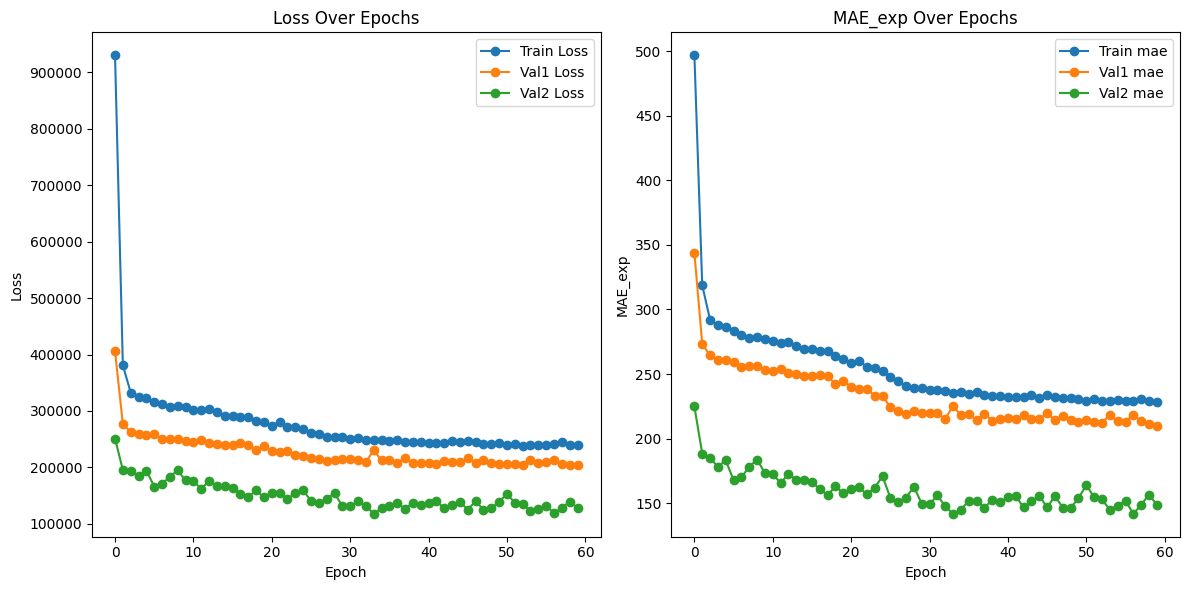

23/23 [==============================] - 0s 3ms/step


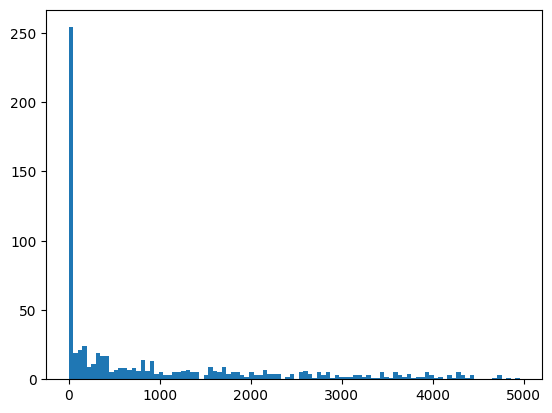

In [15]:
X_train = data_A['X_train'].values
y_train = np.exp(data_A['y_train'].values) - 1

X_val1 = data_A['X_val1'].values
y_val1 = np.exp(data_A['y_val1'].values) - 1
X_val1[np.argwhere(np.isnan(X_val1))] = 0

X_val2 = data_A['X_val2'].values
y_val2 = np.exp(data_A['y_val2'].values) - 1

X_test = data_A['X_test'].values

emb_cols = processor_A.emb_cols

X_train_prepared = prepare_X_data(X_train, emb_cols)
X_val1_prepared = prepare_X_data(X_val1, emb_cols)
X_val2_prepared = prepare_X_data(X_val2, emb_cols)
X_test_prepared = prepare_X_data(X_test, emb_cols)

y_train_prepared = preprare_y_data(y_train)
y_val1_prepared = preprare_y_data(y_val1)
y_val2_prepared = preprare_y_data(y_val2)

modela = create_model()

epochs = 60
train_loss = []
val1_loss = []
val2_loss = []
train_exp_mae = []
val1_exp_mae = []
val2_exp_mae = []

for epoch in tqdm(range(epochs)):
    
    history = modela.fit(X_train_prepared, y_train_prepared, batch_size=64, epochs=1, shuffle=True, verbose=0)
    
    train_loss.append(history.history['loss'][0])
    train_exp_mae.append(history.history['mae'][0])

    val1_history = modela.evaluate(X_val1_prepared, y_val1_prepared, verbose=0)
    val1_loss.append(val1_history[0])
    val1_exp_mae.append(val1_history[1])

    val2_history = modela.evaluate(X_val2_prepared, y_val2_prepared, verbose=0)
    val2_loss.append(val2_history[0])
    val2_exp_mae.append(val2_history[1])

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss', marker='o')
plt.plot(val1_loss, label='Val1 Loss', marker='o')
plt.plot(val2_loss, label='Val2 Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()

# Tworzenie wykresu metryki MAE na zbiorze treningowym i walidacyjnym
plt.subplot(1, 2, 2)
plt.plot(train_exp_mae, label='Train mae', marker='o')
plt.plot(val1_exp_mae, label='Val1 mae', marker='o')
plt.plot(val2_exp_mae, label='Val2 mae', marker='o')
plt.xlabel('Epoch')
plt.ylabel('MAE_exp')
plt.title('MAE_exp Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

preds = modela.predict(X_test_prepared).flatten()
plt.hist(preds, bins=100)
plt.show()

# Save model and preprocessor
modela.save('dense_model_A.h5')

with open('processor_A_dense.pkl', 'wb') as file:
    pkl.dump(processor_A, file)

### B

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_9 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None, 1)]          0           []                               
                                                                                            

  0%|          | 0/60 [00:00<?, ?it/s]

Epoch 1/60
Epoch 2/60
Epoch 3/60
Epoch 4/60
Epoch 5/60
Epoch 6/60
Epoch 7/60
Epoch 8/60
Epoch 9/60
Epoch 10/60
Epoch 11/60
Epoch 12/60
Epoch 13/60
Epoch 14/60
Epoch 15/60
Epoch 16/60
Epoch 17/60
Epoch 18/60
Epoch 19/60
Epoch 20/60
Epoch 21/60
Epoch 22/60
Epoch 23/60
Epoch 24/60
Epoch 25/60
Epoch 26/60
Epoch 27/60
Epoch 28/60
Epoch 29/60
Epoch 30/60
Epoch 31/60
Epoch 32/60
Epoch 33/60
Epoch 34/60
Epoch 35/60
Epoch 36/60
Epoch 37/60
Epoch 38/60
Epoch 39/60
Epoch 40/60
Epoch 41/60
Epoch 42/60
Epoch 43/60
Epoch 44/60
Epoch 45/60
Epoch 46/60
Epoch 47/60
Epoch 48/60
Epoch 49/60
Epoch 50/60
Epoch 51/60
Epoch 52/60
Epoch 53/60
Epoch 54/60
Epoch 55/60
Epoch 56/60
Epoch 57/60
Epoch 58/60
Epoch 59/60
Epoch 60/60


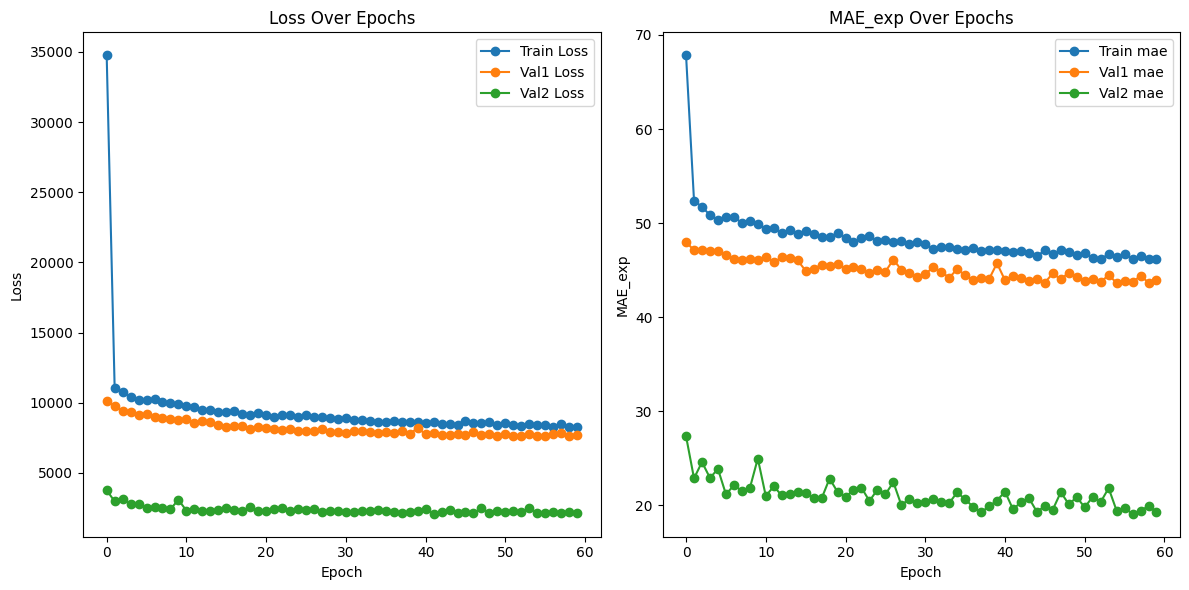

23/23 [==============================] - 0s 2ms/step


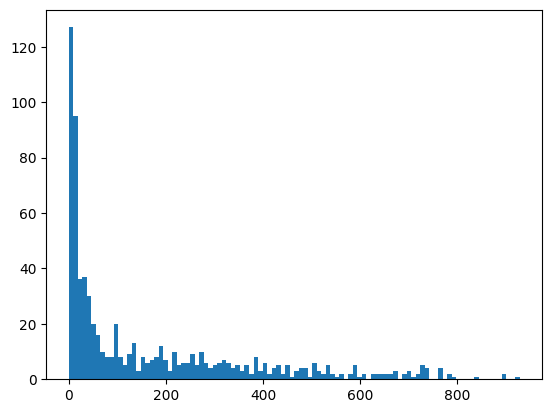

In [16]:
X_train = data_B['X_train'].values
y_train = np.exp(data_B['y_train'].values) - 1

X_val1 = data_B['X_val1'].values
y_val1 = np.exp(data_B['y_val1'].values) - 1
X_val1[np.argwhere(np.isnan(X_val1))] = 0

X_val2 = data_B['X_val2'].values
y_val2 = np.exp(data_B['y_val2'].values) - 1

X_test = data_B['X_test'].values

emb_cols = processor_B.emb_cols

X_train_prepared = prepare_X_data(X_train, emb_cols)
X_val1_prepared = prepare_X_data(X_val1, emb_cols)
X_val2_prepared = prepare_X_data(X_val2, emb_cols)
X_test_prepared = prepare_X_data(X_test, emb_cols)

y_train_prepared = preprare_y_data(y_train)
y_val1_prepared = preprare_y_data(y_val1)
y_val2_prepared = preprare_y_data(y_val2)

modelb = create_model()

epochs = 60
train_loss = []
val1_loss = []
val2_loss = []
train_exp_mae = []
val1_exp_mae = []
val2_exp_mae = []

for epoch in tqdm(range(epochs)):
    
    history = modela.fit(X_train_prepared, y_train_prepared, batch_size=64, epochs=1, shuffle=True, verbose=0)

    train_loss.append(history.history['loss'][0])
    train_exp_mae.append(history.history['mae'][0])

    val1_history = modela.evaluate(X_val1_prepared, y_val1_prepared, verbose=0)
    val1_loss.append(val1_history[0])
    val1_exp_mae.append(val1_history[1])

    val2_history = modela.evaluate(X_val2_prepared, y_val2_prepared, verbose=0)
    val2_loss.append(val2_history[0])
    val2_exp_mae.append(val2_history[1])

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss', marker='o')
plt.plot(val1_loss, label='Val1 Loss', marker='o')
plt.plot(val2_loss, label='Val2 Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()

# Tworzenie wykresu metryki MAE na zbiorze treningowym i walidacyjnym
plt.subplot(1, 2, 2)
plt.plot(train_exp_mae, label='Train mae', marker='o')
plt.plot(val1_exp_mae, label='Val1 mae', marker='o')
plt.plot(val2_exp_mae, label='Val2 mae', marker='o')
plt.xlabel('Epoch')
plt.ylabel('MAE_exp')
plt.title('MAE_exp Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

preds = modela.predict(X_test_prepared).flatten()
plt.hist(preds, bins=100)
plt.show()

# Save model and preprocessor
modela.save('dense_model_B.h5')

with open('processor_B_dense.pkl', 'wb') as file:
    pkl.dump(processor_B, file)

### C

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_13 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_14 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_15 (InputLayer)          [(None, 1)]          0           []                               
                                                                                            

  0%|          | 0/60 [00:00<?, ?it/s]

Epoch 1/60
Epoch 2/60
Epoch 3/60
Epoch 4/60
Epoch 5/60
Epoch 6/60
Epoch 7/60
Epoch 8/60
Epoch 9/60
Epoch 10/60
Epoch 11/60
Epoch 12/60
Epoch 13/60
Epoch 14/60
Epoch 15/60
Epoch 16/60
Epoch 17/60
Epoch 18/60
Epoch 19/60
Epoch 20/60
Epoch 21/60
Epoch 22/60
Epoch 23/60
Epoch 24/60
Epoch 25/60
Epoch 26/60
Epoch 27/60
Epoch 28/60
Epoch 29/60
Epoch 30/60
Epoch 31/60
Epoch 32/60
Epoch 33/60
Epoch 34/60
Epoch 35/60
Epoch 36/60
Epoch 37/60
Epoch 38/60
Epoch 39/60
Epoch 40/60
Epoch 41/60
Epoch 42/60
Epoch 43/60
Epoch 44/60
Epoch 45/60
Epoch 46/60
Epoch 47/60
Epoch 48/60
Epoch 49/60
Epoch 50/60
Epoch 51/60
Epoch 52/60
Epoch 53/60
Epoch 54/60
Epoch 55/60
Epoch 56/60
Epoch 57/60
Epoch 58/60
Epoch 59/60
Epoch 60/60


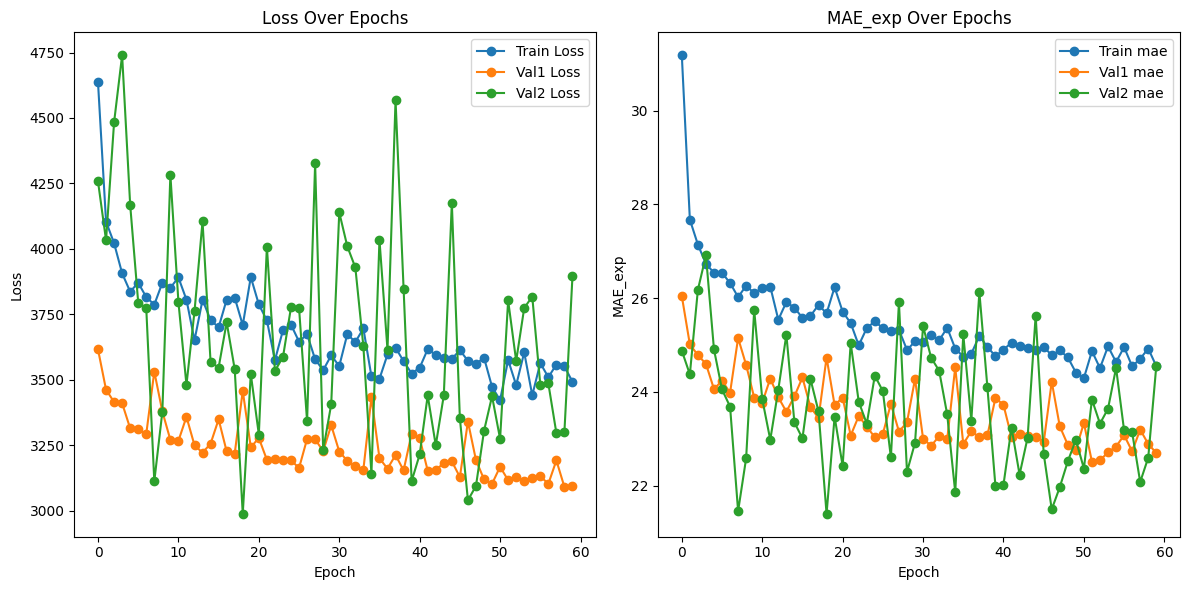

23/23 [==============================] - 0s 1ms/step


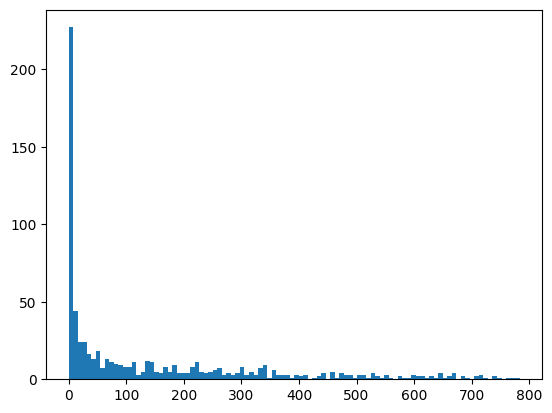

In [17]:
X_train = data_C['X_train'].values
y_train = np.exp(data_C['y_train'].values) - 1

X_val1 = data_C['X_val1'].values
X_val1[np.argwhere(np.isnan(data_C['X_val1'].values))] = 0
y_val1 = np.exp(data_C['y_val1'].values) - 1

X_val2 = data_C['X_val2'].values
y_val2 = np.exp(data_C['y_val2'].values) - 1

X_test = data_C['X_test'].values

emb_cols = processor_C.emb_cols

X_train_prepared = prepare_X_data(X_train, emb_cols)
X_val1_prepared = prepare_X_data(X_val1, emb_cols)
X_val2_prepared = prepare_X_data(X_val2, emb_cols)
X_test_prepared = prepare_X_data(X_test, emb_cols)

y_train_prepared = preprare_y_data(y_train)
y_val1_prepared = preprare_y_data(y_val1)
y_val2_prepared = preprare_y_data(y_val2)

modelc = create_model()

epochs = 60
train_loss = []
val1_loss = []
val2_loss = []
train_exp_mae = []
val1_exp_mae = []
val2_exp_mae = []

for epoch in tqdm(range(epochs)):

    history = modela.fit(X_train_prepared, y_train_prepared, batch_size=64, epochs=1, shuffle=True, verbose=0)

    train_loss.append(history.history['loss'][0])
    train_exp_mae.append(history.history['mae'][0])

    val1_history = modela.evaluate(X_val1_prepared, y_val1_prepared, verbose=0)
    val1_loss.append(val1_history[0])
    val1_exp_mae.append(val1_history[1])

    val2_history = modela.evaluate(X_val2_prepared, y_val2_prepared, verbose=0)
    val2_loss.append(val2_history[0])
    val2_exp_mae.append(val2_history[1])

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss', marker='o')
plt.plot(val1_loss, label='Val1 Loss', marker='o')
plt.plot(val2_loss, label='Val2 Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_exp_mae, label='Train mae', marker='o')
plt.plot(val1_exp_mae, label='Val1 mae', marker='o')
plt.plot(val2_exp_mae, label='Val2 mae', marker='o')
plt.xlabel('Epoch')
plt.ylabel('MAE_exp')
plt.title('MAE_exp Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

preds = modela.predict(X_test_prepared).flatten()
plt.hist(preds, bins=100)
plt.show()

# Save model and preprocessor
modela.save('dense_model_C.h5')

with open('processor_C_dense.pkl', 'wb') as file:
    pkl.dump(processor_C, file)

# Sequence model

In [18]:
XA_test_p, _ = make_dataset_seq(XA_test, sample_sub_A, labels=False)
XB_test_p, _ = make_dataset_seq(XB_test, sample_sub_B, labels=False)
XC_test_p, _ = make_dataset_seq(XC_test, sample_sub_C, labels=False)

XA_train_p, yA_train_p = make_dataset_seq(XA_train, yA_train, labels=True)
XB_train_p, yB_train_p = make_dataset_seq(XB_train, yB_train, labels=True)
XC_train_p, yC_train_p = make_dataset_seq(XC_train, yC_train, labels=True)

XA_val_p, yA_val_p = make_dataset_seq(XA_val, yA_train, labels=True)
XB_val_p, yB_val_p = make_dataset_seq(XB_val, yB_train, labels=True)
XC_val_p, yC_val_p = make_dataset_seq(XC_val, yC_train, labels=True)

  0%|          | 0/720 [00:00<?, ?it/s]

  0%|          | 0/720 [00:00<?, ?it/s]

  0%|          | 0/720 [00:00<?, ?it/s]

  0%|          | 0/34085 [00:00<?, ?it/s]

  0%|          | 0/32844 [00:00<?, ?it/s]

  0%|          | 0/26095 [00:00<?, ?it/s]

  0%|          | 0/34085 [00:00<?, ?it/s]

  0%|          | 0/32844 [00:00<?, ?it/s]

  0%|          | 0/26095 [00:00<?, ?it/s]

## Preprocess data

In [19]:
XA_test_p_split_arr = np.array([len(i) for i in XA_test_p]) == 5
XB_test_p_split_arr = np.array([len(i) for i in XB_test_p]) == 5
XC_test_p_split_arr = np.array([len(i) for i in XC_test_p]) == 5


XA_train_p_split_arr = np.array([len(i) for i in XA_train_p]) == 5
XB_train_p_split_arr = np.array([len(i) for i in XB_train_p]) == 5
XC_train_p_split_arr = np.array([len(i) for i in XC_train_p]) == 5


XA_val_p_split_arr = np.array([len(i) for i in XA_val_p]) == 5
XB_val_p_split_arr = np.array([len(i) for i in XB_val_p]) == 5
XC_val_p_split_arr = np.array([len(i) for i in XC_val_p]) == 5


XA_test_p = XA_test_p[XA_test_p_split_arr]
XB_test_p = XB_test_p[XB_test_p_split_arr]
XC_test_p = XC_test_p[XC_test_p_split_arr]

XA_train_p, yA_train_p = XA_train_p[XA_train_p_split_arr], yA_train_p[XA_train_p_split_arr]
XB_train_p, yB_train_p = XB_train_p[XB_train_p_split_arr], yB_train_p[XB_train_p_split_arr]
XC_train_p, yC_train_p = XC_train_p[XC_train_p_split_arr], yC_train_p[XC_train_p_split_arr]

XA_val_p, yA_val_p = XA_val_p[XA_val_p_split_arr], yA_val_p[XA_val_p_split_arr]
XB_val_p, yB_val_p = XB_val_p[XB_val_p_split_arr], yB_val_p[XB_val_p_split_arr]
XC_val_p, yC_val_p = XC_val_p[XC_val_p_split_arr], yC_val_p[XC_val_p_split_arr]

In [20]:
processor_A = HMSeqPreprocessor(XA_train_p, yA_train_p, XA_val_p, yA_val_p, XA_test_p, validation_split=0.25)
processor_B = HMSeqPreprocessor(XB_train_p, yB_train_p, XB_val_p, yB_val_p, XB_test_p, validation_split=0.25)
processor_C = HMSeqPreprocessor(XC_train_p, yC_train_p, XC_val_p, yC_val_p, XC_test_p, validation_split=0.25)

In [21]:
data_A = processor_A.get_tranformed_data()
data_B = processor_B.get_tranformed_data()
data_C = processor_C.get_tranformed_data()

  0%|          | 0/22249 [00:00<?, ?it/s]

  0%|          | 0/7417 [00:00<?, ?it/s]

  0%|          | 0/4392 [00:00<?, ?it/s]

  0%|          | 0/702 [00:00<?, ?it/s]

  0%|          | 0/21912 [00:00<?, ?it/s]

  0%|          | 0/7305 [00:00<?, ?it/s]

  0%|          | 0/3599 [00:00<?, ?it/s]

  0%|          | 0/702 [00:00<?, ?it/s]

  0%|          | 0/17355 [00:00<?, ?it/s]

  0%|          | 0/5786 [00:00<?, ?it/s]

  0%|          | 0/2928 [00:00<?, ?it/s]

  0%|          | 0/702 [00:00<?, ?it/s]

## Training

### A

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/30
Epoch 2/30
Epoch 3/30
Epoch 4/30
Epoch 5/30
Epoch 6/30
Epoch 7/30
Epoch 8/30
Epoch 9/30
Epoch 10/30
Epoch 11/30
Epoch 12/30
Epoch 13/30
Epoch 14/30
Epoch 15/30
Epoch 16/30
Epoch 17/30
Epoch 18/30
Epoch 19/30
Epoch 20/30
Epoch 21/30
Epoch 22/30
Epoch 23/30
Epoch 24/30
Epoch 25/30
Epoch 26/30
Epoch 27/30
Epoch 28/30
Epoch 29/30
Epoch 30/30


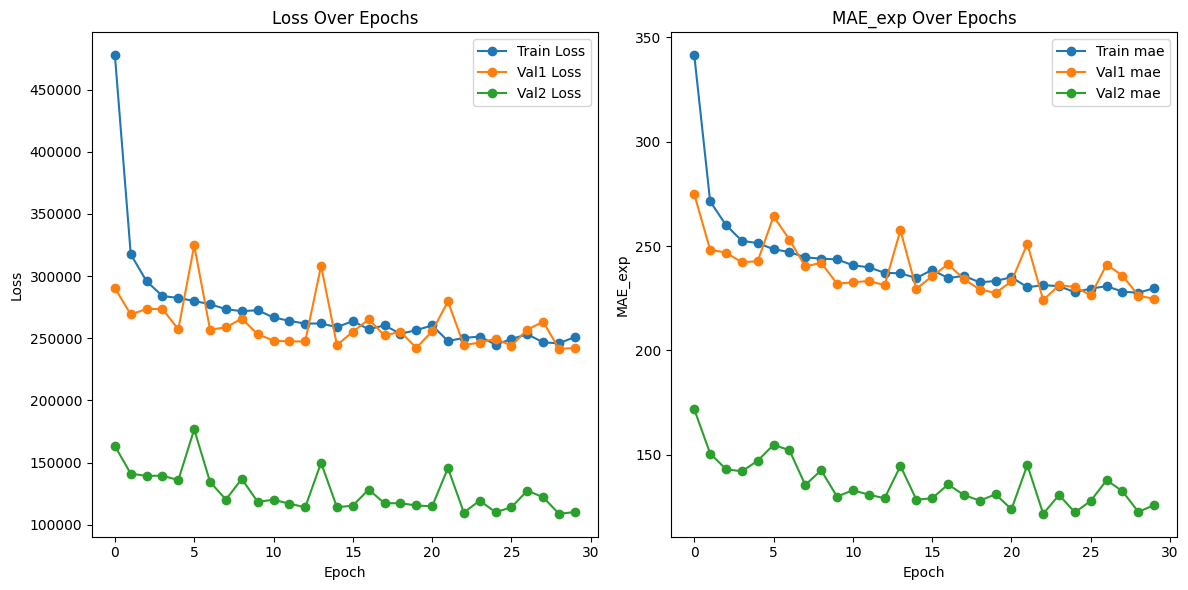

22/22 [==============================] - 1s 12ms/step


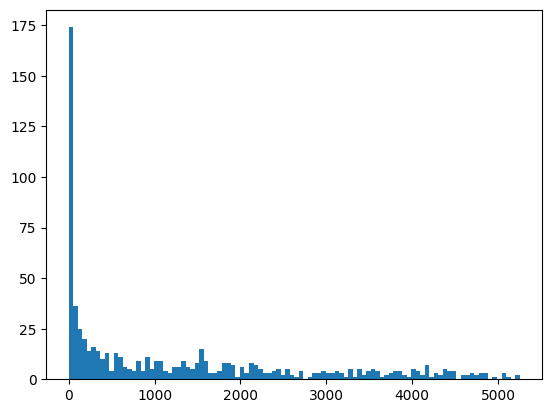

In [22]:
X_train = data_A['X_train']
y_train = np.exp(data_A['y_train']) - 1

X_val1 = data_A['X_val1']
y_val1 = np.exp(data_A['y_val1']) - 1
X_val1[np.argwhere(np.isnan(X_val1))] = 0

X_val2 = data_A['X_val2']
y_val2 = np.exp(data_A['y_val2']) - 1

X_test = data_A['X_test']

emb_cols = processor_A.emb_cols

X_train_prepared = prepare_X_data_seq(X_train, emb_cols)
X_val1_prepared = prepare_X_data_seq(X_val1, emb_cols)
X_val2_prepared = prepare_X_data_seq(X_val2, emb_cols)
X_test_prepared = prepare_X_data_seq(X_test, emb_cols)

y_train_prepared = preprare_y_data(y_train)
y_val1_prepared = preprare_y_data(y_val1)
y_val2_prepared = preprare_y_data(y_val2)

modela = create_model_seq()

epochs = 30
train_loss = []
val1_loss = []
val2_loss = []
train_exp_mae = []
val1_exp_mae = []
val2_exp_mae = []

for epoch in tqdm(range(epochs)):

    history = modela.fit(X_train_prepared, y_train_prepared, batch_size=64, epochs=1, shuffle=True, verbose=0)

    train_loss.append(history.history['loss'][0])
    train_exp_mae.append(history.history['mae'][0])

    val1_history = modela.evaluate(X_val1_prepared, y_val1_prepared, verbose=0)
    val1_loss.append(val1_history[0])
    val1_exp_mae.append(val1_history[1])

    val2_history = modela.evaluate(X_val2_prepared, y_val2_prepared, verbose=0)
    val2_loss.append(val2_history[0])
    val2_exp_mae.append(val2_history[1])

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss', marker='o')
plt.plot(val1_loss, label='Val1 Loss', marker='o')
plt.plot(val2_loss, label='Val2 Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_exp_mae, label='Train mae', marker='o')
plt.plot(val1_exp_mae, label='Val1 mae', marker='o')
plt.plot(val2_exp_mae, label='Val2 mae', marker='o')
plt.xlabel('Epoch')
plt.ylabel('MAE_exp')
plt.title('MAE_exp Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

preds = modela.predict(X_test_prepared).flatten()
plt.hist(preds, bins=100)
plt.show()

# Save model and preprocessor
modela.save('seq_model_A.h5')

with open('processor_A_seq.pkl', 'wb') as file:
    pkl.dump(processor_A, file)

### B

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/30
Epoch 2/30
Epoch 3/30
Epoch 4/30
Epoch 5/30
Epoch 6/30
Epoch 7/30
Epoch 8/30
Epoch 9/30
Epoch 10/30
Epoch 11/30
Epoch 12/30
Epoch 13/30
Epoch 14/30
Epoch 15/30
Epoch 16/30
Epoch 17/30
Epoch 18/30
Epoch 19/30
Epoch 20/30
Epoch 21/30
Epoch 22/30
Epoch 23/30
Epoch 24/30
Epoch 25/30
Epoch 26/30
Epoch 27/30
Epoch 28/30
Epoch 29/30
Epoch 30/30


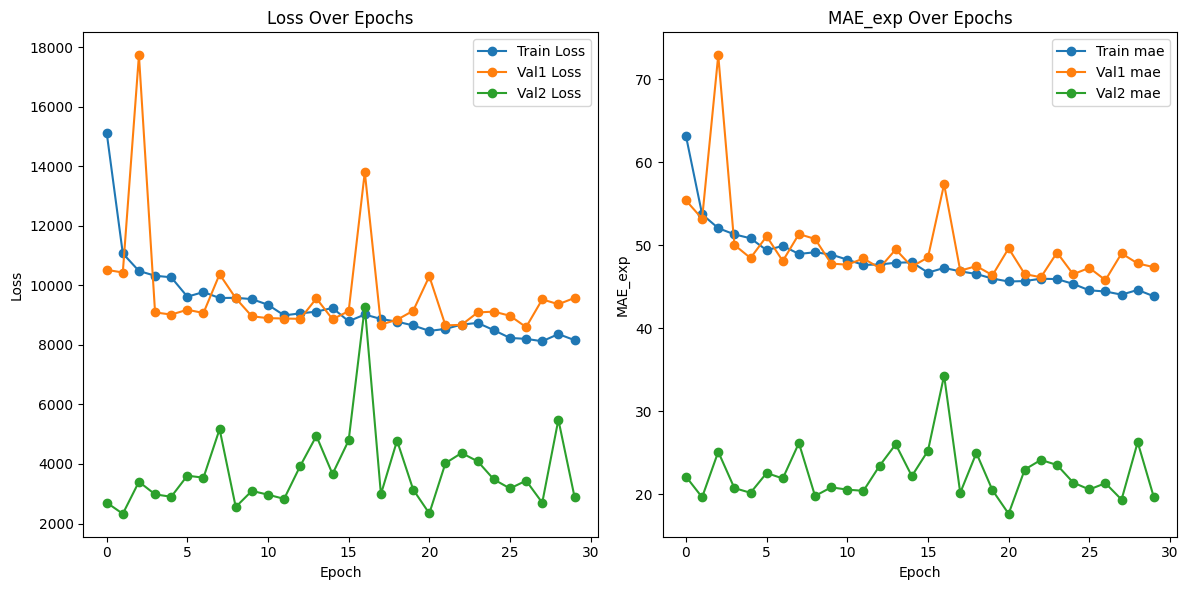

22/22 [==============================] - 1s 7ms/step


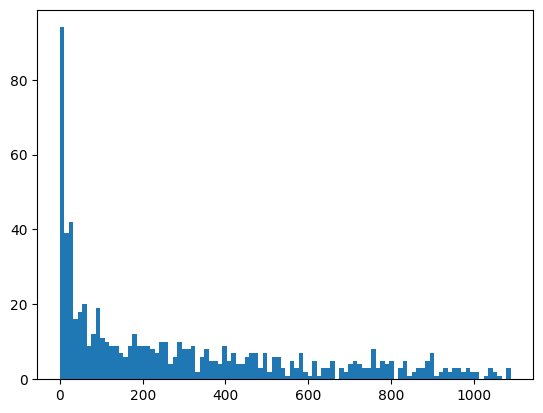

In [23]:
X_train = data_B['X_train']
y_train = np.exp(data_B['y_train']) - 1

X_val1 = data_B['X_val1']
y_val1 = np.exp(data_B['y_val1']) - 1
X_val1[np.argwhere(np.isnan(X_val1))] = 0

X_val2 = data_B['X_val2']
y_val2 = np.exp(data_B['y_val2']) - 1

X_test = data_B['X_test']

emb_cols = processor_B.emb_cols

X_train_prepared = prepare_X_data_seq(X_train, emb_cols)
X_val1_prepared = prepare_X_data_seq(X_val1, emb_cols)
X_val2_prepared = prepare_X_data_seq(X_val2, emb_cols)
X_test_prepared = prepare_X_data_seq(X_test, emb_cols)

y_train_prepared = preprare_y_data(y_train)
y_val1_prepared = preprare_y_data(y_val1)
y_val2_prepared = preprare_y_data(y_val2)

modelb = create_model_seq()

epochs = 30
train_loss = []
val1_loss = []
val2_loss = []
train_exp_mae = []
val1_exp_mae = []
val2_exp_mae = []

for epoch in tqdm(range(epochs)):

    history = modelb.fit(X_train_prepared, y_train_prepared, batch_size=64, epochs=1, shuffle=True, verbose=0)

    train_loss.append(history.history['loss'][0])
    train_exp_mae.append(history.history['mae'][0])

    val1_history = modelb.evaluate(X_val1_prepared, y_val1_prepared, verbose=0)
    val1_loss.append(val1_history[0])
    val1_exp_mae.append(val1_history[1])

    val2_history = modelb.evaluate(X_val2_prepared, y_val2_prepared, verbose=0)
    val2_loss.append(val2_history[0])
    val2_exp_mae.append(val2_history[1])

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss', marker='o')
plt.plot(val1_loss, label='Val1 Loss', marker='o')
plt.plot(val2_loss, label='Val2 Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_exp_mae, label='Train mae', marker='o')
plt.plot(val1_exp_mae, label='Val1 mae', marker='o')
plt.plot(val2_exp_mae, label='Val2 mae', marker='o')
plt.xlabel('Epoch')
plt.ylabel('MAE_exp')
plt.title('MAE_exp Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

preds = modelb.predict(X_test_prepared).flatten()
plt.hist(preds, bins=100)
plt.show()

# Save model and preprocessor
modelb.save('seq_model_B.h5')

with open('processor_B_seq.pkl', 'wb') as file:
    pkl.dump(processor_B, file)

### C

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/30
Epoch 2/30
Epoch 3/30
Epoch 4/30
Epoch 5/30
Epoch 6/30
Epoch 7/30
Epoch 8/30
Epoch 9/30
Epoch 10/30
Epoch 11/30
Epoch 12/30
Epoch 13/30
Epoch 14/30
Epoch 15/30
Epoch 16/30
Epoch 17/30
Epoch 18/30
Epoch 19/30
Epoch 20/30
Epoch 21/30
Epoch 22/30
Epoch 23/30
Epoch 24/30
Epoch 25/30
Epoch 26/30
Epoch 27/30
Epoch 28/30
Epoch 29/30
Epoch 30/30
22/22 [==============================] - 0s 4ms/step


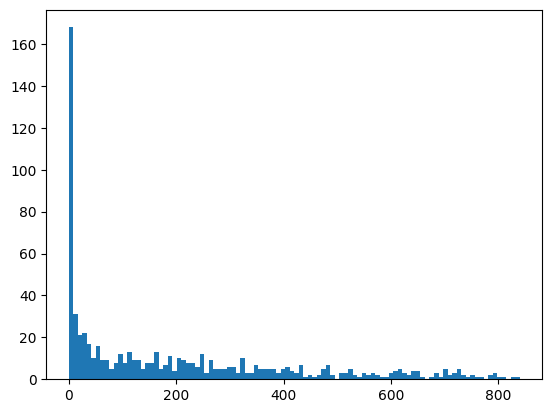

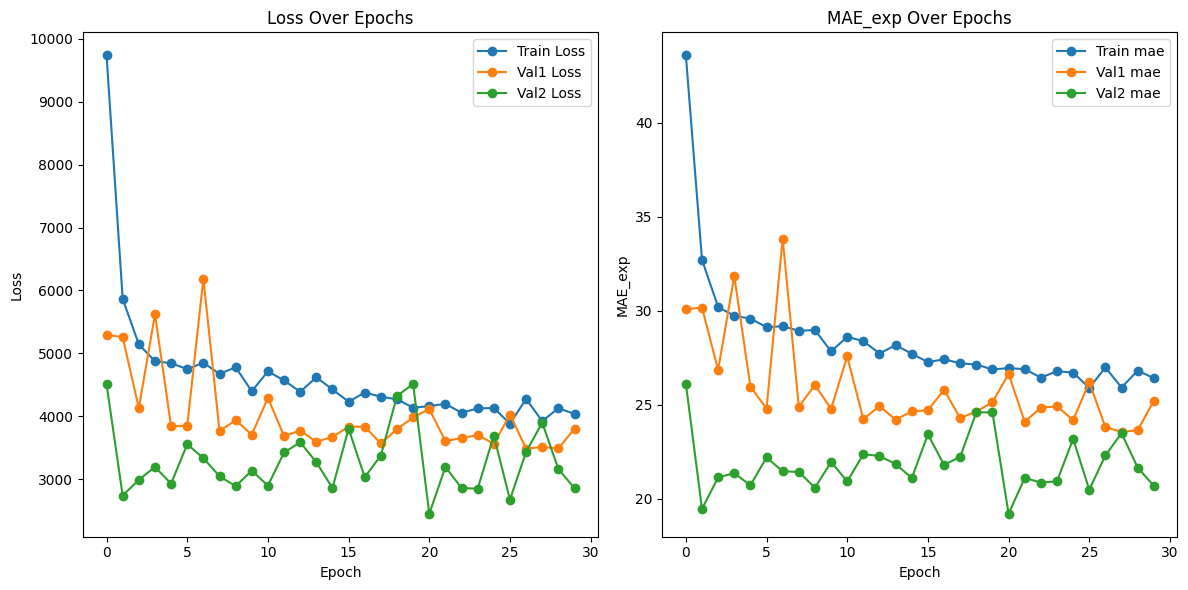

In [24]:
X_train = data_C['X_train']
y_train = np.exp(data_C['y_train']) - 1

X_val1 = data_C['X_val1']
y_val1 = np.exp(data_C['y_val1']) - 1
X_val1[np.argwhere(np.isnan(X_val1))] = 0

X_val2 = data_C['X_val2']
y_val2 = np.exp(data_C['y_val2']) - 1

X_test = data_C['X_test']

emb_cols = processor_C.emb_cols

X_train_prepared = prepare_X_data_seq(X_train, emb_cols)
X_val1_prepared = prepare_X_data_seq(X_val1, emb_cols)
X_val2_prepared = prepare_X_data_seq(X_val2, emb_cols)
X_test_prepared = prepare_X_data_seq(X_test, emb_cols)

y_train_prepared = preprare_y_data(y_train)
y_val1_prepared = preprare_y_data(y_val1)
y_val2_prepared = preprare_y_data(y_val2)

modelc = create_model_seq()

epochs = 30
train_loss = []
val1_loss = []
val2_loss = []
train_exp_mae = []
val1_exp_mae = []
val2_exp_mae = []

for epoch in tqdm(range(epochs)):

    history = modelc.fit(X_train_prepared, y_train_prepared, batch_size=64, epochs=1, shuffle=True, verbose=0)

    train_loss.append(history.history['loss'][0])
    train_exp_mae.append(history.history['mae'][0])

    val1_history = modelc.evaluate(X_val1_prepared, y_val1_prepared, verbose=0)
    val1_loss.append(val1_history[0])
    val1_exp_mae.append(val1_history[1])

    val2_history = modelc.evaluate(X_val2_prepared, y_val2_prepared, verbose=0)
    val2_loss.append(val2_history[0])
    val2_exp_mae.append(val2_history[1])

preds = modelc.predict(X_test_prepared).flatten()
plt.hist(preds, bins=100)
plt.show()

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss', marker='o')
plt.plot(val1_loss, label='Val1 Loss', marker='o')
plt.plot(val2_loss, label='Val2 Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_exp_mae, label='Train mae', marker='o')
plt.plot(val1_exp_mae, label='Val1 mae', marker='o')
plt.plot(val2_exp_mae, label='Val2 mae', marker='o')
plt.xlabel('Epoch')
plt.ylabel('MAE_exp')
plt.title('MAE_exp Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()


# Save model and preprocessor
modelc.save('seq_model_C.h5')

with open('processor_C_seq.pkl', 'wb') as file:
    pkl.dump(processor_C, file)

# Combined model & submission

## Load models and preprocessors

In [25]:
processor_A_dense = save_open_pkl('processor_A_dense.pkl')
processor_B_dense = save_open_pkl('processor_B_dense.pkl')
processor_C_dense = save_open_pkl('processor_C_dense.pkl')

dense_model_A = tf.keras.models.load_model('dense_model_A.h5')
dense_model_B = tf.keras.models.load_model('dense_model_B.h5')
dense_model_C = tf.keras.models.load_model('dense_model_C.h5')

processor_A_seq = save_open_pkl('processor_A_seq.pkl')
processor_B_seq = save_open_pkl('processor_B_seq.pkl')
processor_C_seq = save_open_pkl('processor_C_seq.pkl')

lstm_model_A = tf.keras.models.load_model('seq_model_A.h5')
lstm_model_B = tf.keras.models.load_model('seq_model_B.h5')
lstm_model_C = tf.keras.models.load_model('seq_model_C.h5')

## Run models on test data

In [26]:
for i in tqdm(range(len(sample_sub))):

    s = sample_sub.iloc[i]
    
    if s['Category'] == 'A':
        c = 'A'
        sample = select_records_in_time_range(XA_test, s['date_forecast'])
        if len(sample) == 5:
            t = 'seq'
            input_sample = prepare_X_data_seq(processor_A_seq._whole_pipeline(sample).values.reshape((1, 5, -1)), processor_A_seq.emb_cols)
            pred = lstm_model_A.predict(input_sample, verbose=0)
        elif len(sample) == 1:
            t = 'dense'
            input_sample = prepare_X_data(processor_A_dense._whole_pipeline(sample).values, processor_A_dense.emb_cols)
            pred = dense_model_A.predict(input_sample, verbose=0)
        else:
            raise()

    elif s['Category'] == 'B':
        c = 'B'
        sample = select_records_in_time_range(XB_test, s['date_forecast'])
        if len(sample) == 5:
            t = 'seq'
            input_sample = prepare_X_data_seq(processor_B_seq._whole_pipeline(sample).values.reshape((1, 5, -1)), processor_A_seq.emb_cols)
            pred = lstm_model_B.predict(input_sample, verbose=0)
        elif len(sample) == 1:
            t = 'dense'
            input_sample = prepare_X_data(processor_B_dense._whole_pipeline(sample).values, processor_B_dense.emb_cols)
            pred = dense_model_B.predict(input_sample, verbose=0)
        else:
            raise()

    elif s['Category'] == 'C':
        c = 'C'
        sample = select_records_in_time_range(XC_test, s['date_forecast'])
        if len(sample) == 5:
            t = 'seq'
            input_sample = prepare_X_data_seq(processor_C_seq._whole_pipeline(sample).values.reshape((1, 5, -1)), processor_A_seq.emb_cols)
            pred = lstm_model_C.predict(input_sample, verbose=0)
        elif len(sample) == 1:
            t = 'dense'
            input_sample = prepare_X_data(processor_C_dense._whole_pipeline(sample).values, processor_C_dense.emb_cols)
            pred = dense_model_C.predict(input_sample, verbose=0)
        else:
            raise()
    pred = pred.flatten()[0]
    sample_sub['pv_measurement'][i] = pred

  0%|          | 0/2160 [00:00<?, ?it/s]

## Save submission

In [27]:
submission = sample_sub[['id', 'pv_measurement']]
submission = submission.rename(columns={'pv_measurement': 'prediction'})
submission.to_csv('test_sub.csv', index=False)